In [19]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [1]:
import numpy as np
from scipy.sparse import csr_array, lil_array
import matplotlib.pyplot as plt
import pandas as pd
import math
import pickle
import time
import datetime
import random
from pprint import pprint
from lightgbm import LGBMRanker
from sklearn.model_selection import train_test_split

from SVD import Metrics, SVDPredictor, FastLogisticSVD
from RecData import RecData

In [2]:
# recs = pd.read_csv('data/recommendations.csv')
recs = pd.read_csv('data/pruned.csv')
# recs = pd.read_csv('data/2plus.csv')

# Remove old ratings
recs = recs.sort_values(by=['date'], ascending=False)
recs.drop_duplicates(subset= ['app_id', 'user_id'], inplace=True) 

USED_COLS = ['app_id', 'is_recommended', 'user_id']
recs = recs[USED_COLS]

item_data = pd.read_csv('data/games.csv')
titles = item_data[['app_id', 'title']]

print("Shape:", recs.shape)
recs.sort_values(by=['user_id', 'app_id']).head()

Shape: (1482532, 3)


,app_id,is_recommended,user_id
629351,12210,True,240
116928,22380,True,240
1418125,239140,True,240
236273,251570,True,240
87206,270880,True,240


In [3]:
random.seed(42)
np.random.seed(42)

rec_data = RecData()
rec_data.create_from_dataframe(recs)
rec_data.set_titles(titles)

# del recs

start_time = time.time()
print("Creating splits...")
train_data, test = rec_data.train_test_split(test_size=0.2)
print("First split done.")
train_data, val = train_data.train_test_split(test_size=0.2)
print("Done creating splits in", time.time() - start_time, "seconds")

Creating utility matrix...
Done utility matrix.
Creating splits...
First split done.
Done creating splits in 4.666291236877441 seconds


In [4]:
del rec_data
del item_data
del titles

## Ranker

This was used as a postprocessing step after using item-knn for candidate generation. Was not able to get good results.

In [5]:
# train = train_data.generate_dataframe()
# X_train = train[['app_id', 'user_id']]
# y_train = train['is_recommended'].to_numpy()

# X_train = X_train.sort_values(by='user_id')
# counts = X_train['user_id'].value_counts(sort=False)
# X_train = X_train[['app_id']]

In [6]:
# ranker = LGBMRanker(n_estimators=300, random_state=42, objective='lambdarank')
# ranker = ranker.fit(X_train, y_train, group = counts.values, categorical_feature=['app_id'],
#                     eval_set=[(X_train, y_train)], eval_group=[counts.values], 
#                     eval_at=20)

## Training SVD

In [ ]:
# for pruned, epoch: 30, lr:0.01, reg:0.02, k=50

EPOCHS = 35

random.seed(42)
np.random.seed(42)

# Fit and predict with svd
svd_predictor = FastLogisticSVD(
    train_data.get_num_users(), train_data.get_num_items(), 2, k=40, 
    learning_rate=0.01, C=0.68)
svd_predictor.fit(train_data.get_matrix(), EPOCHS, validation_set=val, early_stop=False)

# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(len(errors)), errors, label='Training error')
plt.plot(range(len(val_errors)), val_errors, label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

# Compute rmse
predictions = svd_predictor.predict_pairs([(user, item) for user, item, _ in val])
predictions = [prediction + (val[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
rmse = metrics.rmse(predictions)
print("Test rmse", rmse)

Epoch 0/Training error: 0.45950317786885037/Validation error: 0.4612008624472964/Time: 6.61 seconds
Epoch 1/Training error: 0.4404730192400114/Validation error: 0.4434848932228774/Time: 4.21 seconds
Epoch 2/Training error: 0.4305012788185489/Validation error: 0.43476125154145867/Time: 4.2 seconds
Epoch 3/Training error: 0.4232642095214551/Validation error: 0.4286637518240874/Time: 4.16 seconds


We can now continue to train if we believe the model is still underfitting.

In [59]:
svd_predictor.continue_fit(10, early_stop=False)

Epoch 0/Training error: 0.5694916962994313/Validation error: 0.574764728289678/Time: 4.49 seconds
Epoch 1/Training error: 0.5699393021235365/Validation error: 0.5752063614656718/Time: 4.7 seconds
Epoch 2/Training error: 0.569499560086825/Validation error: 0.5747476654195321/Time: 4.31 seconds
Epoch 3/Training error: 0.5692221928274703/Validation error: 0.5744473602779012/Time: 4.56 seconds
Epoch 4/Training error: 0.5694623970288204/Validation error: 0.5747027210135377/Time: 4.36 seconds
Epoch 5/Training error: 0.5694495839194854/Validation error: 0.5746689832462141/Time: 4.51 seconds
Epoch 6/Training error: 0.5692911094935988/Validation error: 0.5745035548648397/Time: 4.57 seconds
Epoch 7/Training error: 0.5691407155621729/Validation error: 0.5743602776958172/Time: 4.67 seconds
Epoch 8/Training error: 0.5691432825587514/Validation error: 0.5743697579438373/Time: 4.72 seconds
Epoch 9/Training error: 0.5693285965177441/Validation error: 0.574539638142911/Time: 4.65 seconds


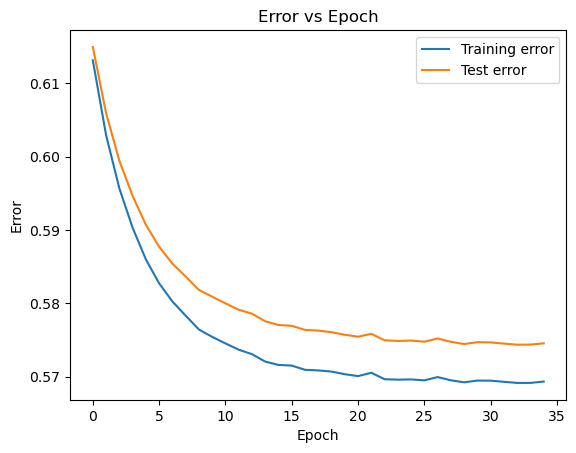

Test rmse 0.4377199721242661


In [60]:
# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(len(errors)), errors, label='Training error')
plt.plot(range(len(val_errors)), val_errors, label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

# Compute rmse
predictions = svd_predictor.predict_pairs([(user, item) for user, item, _ in val])
predictions = [prediction + (val[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
rmse = metrics.rmse(predictions)
print("Test rmse", rmse)

We compute similarities for item-knn.

In [61]:
svd_predictor.compute_sims()

Computing similarities...
Upto row 0
Upto row 200
Upto row 400
Upto row 600
Upto row 800
Upto row 1000
Upto row 1200
Upto row 1400
Upto row 1600
Upto row 1800
Upto row 2000
Upto row 2200
Done computing similarities in 411.1374592781067 seconds


In [17]:
# Ensure file exists
model_dir = model_dir = "saved_models/{}-{}-{}-{}-{}-{}_{}".format(
    *(time.localtime()[:6] + (round(rmse, 4), ))).replace(".", "-") + ".pkl" 
file = open(model_dir, 'a')
file.close()

# Save model
print("Saving model...")
with open(model_dir, 'wb') as file:
    pickle.dump([train_data, svd_predictor], file)
print("Done saving model.")

Saving model...
Done saving model.


## Tests

In [6]:
with open('model.pkl', 'rb') as file:
    data, svd_predictor = pickle.load(file)

### Testing Rerank

In [10]:
# data.search_title('forza')

In [11]:
# filtered = svd_predictor.items_top_n([(286, 1)])
# app_ids = []
# for item_index in filtered:
#     app_ids.append(data.index_to_item_id(item_index))
# df = pd.DataFrame({'app_id': app_ids})
# predictions = ranker.predict(df)
# df['relevance'] = predictions
# df.head()
# df = df.sort_values(by='relevance', ascending=False)
# df.head()

In [12]:
# pprint([[data.index_to_title(data.item_id_to_index(i)) for _, i, _ in df.itertuples()]][0][:20])

### Testing Performance

In [ ]:
start_time = time.time()
print("Computing recall...")
svd_predictor.compute_recall(val)
print("Done computing recall in", time.time() - start_time, "seconds")

In [72]:
train_data.search_title('slay')

[('Demon Slayer -Kimetsu no Yaiba- The Hinokami Chronicles', 397),
 ('Slay the Spire', 325),
 ('Skul: The Hero Slayer', 1790)]

In [73]:
top = svd_predictor.items_knn([(325, 1)])
pprint([(sim, train_data.index_to_title(index)) for sim, index in top])

[(0.9785503831686183, 'Tomb Raider IV: The Last Revelation'),
 (0.9747429632677254, 'Learn to Fly 3'),
 (0.9722935893412307, "THE KING OF FIGHTERS '98 ULTIMATE MATCH FINAL EDITION"),
 (0.9413360158255438, 'FINAL FANTASY XV WINDOWS EDITION'),
 (0.9309407834402053, 'ONE PUNCH MAN: A HERO NOBODY KNOWS'),
 (0.9253527159193456, 'Meadow'),
 (0.9200132815887162, 'Tricky Towers'),
 (0.9171682886395832, 'Evil West'),
 (0.9076439959863917, 'Mount & Blade'),
 (0.9073042589523007, '侠客风云传(Tale of Wuxia)')]


In [13]:
j = 1

# Test top-n list for user j
top_n = svd_predictor.top_n(j, 20)
print("Predicted top n:")
pprint([(r, train_data.index_to_title(index)) for r, index in top_n])

# User j true top n list
print("True top n:")
true_top = train_data.top_n(j, 5000)
pprint([train_data.index_to_title(index) for _, index in true_top])

AttributeError: 'FastLogisticSVD' object has no attribute '_sims'

In [ ]:
# values, bins = np.histogram(svd_predictor._user_features[0, :])
# plt.stairs(values, bins)
# plt.show()

In [21]:
train_data.search_title('forza')

[('Forza Horizon 4', 341), ('Forza Horizon 5', 286)]

In [22]:
prefs = [(196, 0), (740, 1), (174, 1), (819, 1)]
# prefs = [(5, 1), (229, 1), (966, 0)]
pprint([(index, train_data.index_to_title(index), pref) for index, pref in prefs])
prefs = train_data.create_prefs(prefs)    

[(196, 'Minecraft Dungeons', 0),
 (740, 'Century: Age of Ashes', 1),
 (174, 'Core Keeper', 1),
 (819, 'Tomb Raider', 1)]


In [ ]:
start_time = time.time()
svd_predictor.partial_fit(prefs, epochs=EPOCHS)
print("Completed partial fit in", time.time() - start_time, "seconds")

In [ ]:
top_n = svd_predictor.top_n(svd_predictor._num_users - 1, 20)
print("Predicted top n")
pprint([(r, train_data.index_to_title(index)) for r, index in top_n])